In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from cvae_model import ConditionalVAE

/home/tignjatov/anaconda3/envs/ml/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
CHANNELS_IMG = 1
IMG_SIZE = 32
BATCH_SIZE = 64
EPOCHS = 5

In [5]:
def calculate_conv_shape(input_size,kernel_size,stride=0,padding=0):
        return (input_size - kernel_size + 2 * padding) / stride + 1

In [6]:
transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

In [7]:
trainset = torchvision.datasets.MNIST(root='../data', 
                                      train=True,
                                      transform=transform,
                                      download= True)
testset = torchvision.datasets.MNIST(root='../data', 
                                      train=False,
                                      transform=transform,
                                      download= True)

In [8]:
train_dataloarder = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
len(trainset.classes)

10

In [10]:
dataiter = iter(train_dataloarder)
img,lab = dataiter.next()

In [11]:
lab.shape

torch.Size([64])

In [12]:
calculate_conv_shape(4,4,2,1)

2.0

In [14]:
model = ConditionalVAE(in_channels=CHANNELS_IMG,latent_dim=2,num_classes=len(trainset.classes),image_size=IMG_SIZE,device=device)

In [15]:
model.to(device)

ConditionalVAE(
  (embed_class): Embedding(10, 1024)
  (encoder): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (5): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [17]:
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x.flatten(1), x.flatten(1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [18]:
writer_real = SummaryWriter(f"logs/CVAE_MNIST/real")
writer_fake = SummaryWriter(f"logs/CVAE_MNIST/fake")
step = 0
train_losses = []
test_losses = []
for epoch in range(EPOCHS):
    train_epoch_loss = 0
    test_epoch_loss = 0
    for batch_idx,(img,lab) in enumerate(train_dataloarder):
        model.train()
        img = img.to(device)
        lab = lab.to(device)
        optimizer.zero_grad()
        recon_img, mu, log_var = model(img,lab)
        #print(mu)
        #print(log_var)
        loss = loss_function(recon_img, img, mu, log_var)
        #print(loss)
        #print(recon_img.shape)
        #print(loss.item())
        train_epoch_loss += loss.item() 
        loss.backward()
        optimizer.step()
    
        model.eval()
        if batch_idx % 100 == 0 and batch_idx > 0:

                with torch.no_grad():
                    gen_img = model.sample(BATCH_SIZE,lab)
                    # take out (up to) 32 examples
                    img_grid_real = torchvision.utils.make_grid(img[:32], normalize=True)
                    img_grid_fake = torchvision.utils.make_grid(gen_img[:32], normalize=True)

                    writer_real.add_image("Real_cvae", img_grid_real, global_step=step)
                    writer_fake.add_image("Fakec_cvae", img_grid_fake, global_step=step)
                print(
                    f"Epoch [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(train_dataloarder)} \
                      Loss : {train_epoch_loss:.4f} Step : {step}"
                )
                step += 1
    train_losses.append(train_epoch_loss/BATCH_SIZE)
    model.eval()
    with torch.no_grad():
        for img,lab in test_loader:
            img = img.to(device)
            lab = lab.to(device)
            recon_img, mu, log_var = model(img,lab)
            loss = loss_function(recon_img, img, mu, log_var)
            test_epoch_loss += loss.item()
    test_losses.append(test_epoch_loss/BATCH_SIZE)

Epoch [0/5] Batch 100/938                       Loss : 3487535.6934 Step : 0
Epoch [0/5] Batch 200/938                       Loss : 4627883.8188 Step : 1
Epoch [0/5] Batch 300/938                       Loss : 4731493.2534 Step : 2
Epoch [0/5] Batch 400/938                       Loss : 3889962.8644 Step : 3
Epoch [0/5] Batch 500/938                       Loss : 2136851.2990 Step : 4
Epoch [0/5] Batch 600/938                       Loss : -498546.6912 Step : 5
Epoch [0/5] Batch 700/938                       Loss : -3952667.2654 Step : 6
Epoch [0/5] Batch 800/938                       Loss : -8219668.0467 Step : 7
Epoch [0/5] Batch 900/938                       Loss : -13290274.4061 Step : 8
Epoch [1/5] Batch 100/938                       Loss : -6194499.6406 Step : 9
Epoch [1/5] Batch 200/938                       Loss : -13074023.2266 Step : 10
Epoch [1/5] Batch 300/938                       Loss : -20643852.6094 Step : 11
Epoch [1/5] Batch 400/938                       Loss : -28963821.

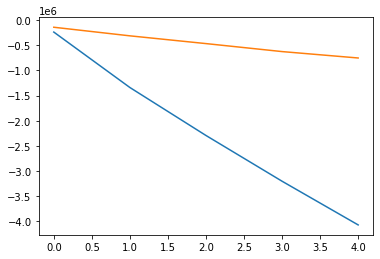

In [19]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.show()

In [20]:
train_losses

[-239543.49889850616,
 -1340164.4792480469,
 -2292513.850463867,
 -3200728.2055664062,
 -4068026.9580078125]

In [21]:
lab.unsqueeze(1).shape

torch.Size([16, 1])

In [22]:
import numpy as np
def imshow(img):
    img = img    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

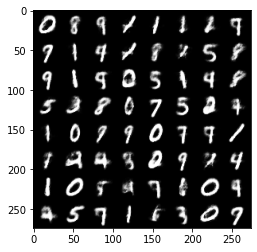

In [23]:
imshow(torchvision.utils.make_grid(gen_img.detach().cpu()))

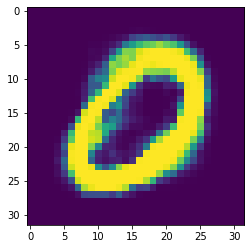

In [24]:
imshow(gen_img[0].detach().cpu())